[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/efviodo/idatha-data-science-course/blob/master/notebooks/06%20-%20DS%20-%20Preparacion%20de%20Datos%20y%20Visualizacion%20-%20R.ipynb)

<img src="https://github.com/efviodo/idatha-data-science-course/raw/master/notebooks/figures/idatha-logo.jpeg" width="100px" height="100px" style="float:left"/>

# Preparación de Datos y Visualización

## Objetivos

- Entender mediante un ejemplo algunos casos de
   - Validaciones y limpieza de datos
   - Transformaciones
- Mostrar un ejemplo de visualización de datos efectiva

## Antes de ejecutar el Notebook

Asegúrese de tener descargado en una carpeta de su preferencia, todos los archivos .csv correspondientes al juego de datos que se utilizan en este Notebook. En particular asegurarse que el directorio donde descarge los archivos sea coherente con el valor de la constante definida al inicio de este documento, cuyo nombre es DATASET_DIR.

<a id='Indice'></a>
## Índice
[Inicio ▲](#Indice)

1. [Dependencias](#Dependencias)
1. [Funciones](#Funciones)
1. [Adquisición de Datos](#Adquisicion)
    1. [Datos del Censo](#DatosDelCenso)
    1. [Códigos de especie](#CodigosDeEspecie)
    1. [Cruces de vias Montevideo](#CrucesViasMontevideo)
1. [Análisis de especies más frecuentes](#EspeciesMasFrecuentes)
    1. [Worcloud de especies](#WordcloudEspecies)
1. [Geolocalización por especie](#GeolocalizacionPorEspecie)
1. [Bibliografía](#Bibliografia)

<a id='Dependencias'></a>
## Dependencias
[Inicio ▲](#Indice)

**Instalación de dependencias**

In [1]:
install.packages("tm")  # for text mining
install.packages("SnowballC") # for text stemming
install.packages("wordcloud") # word-cloud generator 
install.packages("RColorBrewer") # color palettes

**Carga de dependencias**

In [1]:
library("downloader") 
library("dplyr")
library("tm")
library("SnowballC")
library("wordcloud")
library("RColorBrewer")
library("tidyverse")
library("osmdata")
library("ggmap")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: NLP
Loading required package: RColorBrewer
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ readr   1.1.1
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ ggplot2 3.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
Data (c) OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright
Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.


<a id='Constantes'></a>
## Constantes
[Inicio ▲](#Indice)

In [2]:
DATASET_DIR <- 'datasets/censo-arbolado-mvdo'

<a id='Funciones'></a>
## Funciones
[Inicio ▲](#Indice)

In [3]:
dataFrameFromCSV <- function(filename, encoding="UTF-8") {
    delim = "," 
    dec = "."
    quote = "\""
    dataFrame <- read.csv(filename, header=TRUE, sep=delim, quote=quote, dec=dec,
                         encoding=encoding)
    
    return(dataFrame)
}

<a id='Adquisicion'></a>
## Adquisición de Datos
[Inicio ▲](#Indice)


Para este ejemplo vamos a utilizar el dataset de censo de arbolado de la ciudad de Montevideo y analizar ciertas carecterísticas sobre el arbolado de la ciudad de montevideo.

Información del dataset disponible en: https://catalogodatos.gub.uy/dataset/censo-de-arbolado-2008.

Dentro del juego de datos vamos a encontrar varios conjuntos de datos:
- Censo Arbolado
- Códigos de especie

Veamos la adquisición de datos para cada uno de estos datasets.


<a id='DatosDelCenso'></a>
### Datos del censo
[Inicio ▲](#Indice)

#### Descripción
Los datos del censo de arbolado, es propiamente hablando al información del censo, en la cual vamos a encontrar para cada árbol de Montevideo, diferente información de interes.

#### Problemas
Algunos de los archivos csv del dataset completo, tienen pequeños problemas estructurales que deben solucionarse para realizar la carga completa de los datos. A continuación enumero los principales y como se resolvieron

**1. Problema con nombres de columnas**

Los siguientes documentos tenían diferentes nombres de columnas que el resto, por lo que primero debemos remplazar el cabezal o de lo contrario no podremos hacer el bind entre los datasets.

- archivo_comunal16.csv
- archivo_comunal1.csv

**2. Columna adicional**
    
A diferencia del resto del dataset, el documento archivo_comunal8.csv tiene una columna extra, lo cual impide el \"bind\" de los datos de este documento con los otros. Analizando el contenido del documento, puede notarse que la columna extra, es la última columna y está vacía. Por lo tanto, podemos interpretarlo como un descuido en el armado del dataset y suprimirla.

*Solución*:

Remmplazar con la expresión regular ```,,\\n``` por ```,\\n```.

#### Carga de los datos

Cargo los datos de todos los csv en un solo data frame, utilizando mi función auxiliar.

In [4]:
files <- c(
          'archivo_comunal1.csv', 
          'archivo_comunal2.csv', 
          'archivo_comunal3.csv', 
          'archivo_comunal4.csv',
          'archivo_comunal5.csv',
          'archivo_comunal6.csv',
          'archivo_comunal7.csv',
          'archivo_comunal8.csv',
          'archivo_comunal9.csv',
          'archivo_comunal10.csv',
          'archivo_comunal11.csv',
          'archivo_comunal12.csv',
          'archivo_comunal13.csv',
          'archivo_comunal14.csv',
          'archivo_comunal15.csv',
          'archivo_comunal16.csv',
          'archivo_comunal17.csv',
          'archivo_comunal18.csv'
)

dataFrame <- NULL
for (i in 1:length(files)) { 
    fileName <- paste(DATASET_DIR, files[i], sep="/")
    part <- dataFrameFromCSV(fileName)
    dataFrame <- rbind(dataFrame, part)
}

Warning message in `[<-.factor`(`*tmp*`, ri, value = c(226551L, 226552L, 226553L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(7641L, 7641L, 7641L, 7641L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(3348L, 3348L, 3348L, 3348L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(3840L, 3840L, 3840L, 3840L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(3426L, 3426L, 3440L, 3440L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(4L, 4L, 4L, 4L, 4L, 4L, 4L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(15L, 80L, 3L, 141L, 220L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*tmp*`, ri, value = c(2L, 2L, 1L, 3L, 4L, 3L, 3L, :
“invalid factor level, NA generated”Warning message in `[<-.factor`(`*t

Veamos que columnas tenemos así nos familiarizamos con el dataset.

In [5]:
colnames(dataFrame)

[1] "Arbol"             "Cod_calle"         "Calle"            
 [4] "Cod_Entre"         "Entre"             "Cod_Y"            
 [7] "Y"                 "Numero"            "Ajuste"           
[10] "Acera"             "Alineacion"        "Ordinal"          
[13] "Ancho.Vereda"      "Distancia"         "CAP"              
[16] "Altura"            "Diametro.Copa"     "EV"               
[19] "Int.Aerea"         "Int.Sub"           "Genero"           
[22] "Especie"           "Nombre.científico"

In [6]:
# Recordemos cuantos datos estamos analizando
dim(dataFrame)

[1] 211512     23

In [7]:
# Me quedo con algunas de las columnas para apreciar mejor los datos
subset <- dataFrame %>% select("Genero", "Especie", "Nombre.científico")
head(subset, 10)

Genero,Especie,Nombre.científico
<fct>,<fct>,<fct>
28,1,Enterolobium contortisiliquum
28,1,Enterolobium contortisiliquum
28,1,Enterolobium contortisiliquum
63,2,Platanus occidentalis
63,2,Platanus occidentalis
63,2,Platanus occidentalis
63,2,Platanus occidentalis
63,2,Platanus occidentalis
63,2,Platanus occidentalis


In [56]:
# Investigemos un poco más acerca de los datos
str(dataFrame)

'data.frame':	211512 obs. of  23 variables:
 $ Arbol            : Factor w/ 182460 levels "1","100","1000",..: 792 793 794 4341 4342 4343 4344 4345 4346 4347 ...
 $ Cod_calle        : Factor w/ 2124 levels "","126","1482",..: 77 77 77 77 77 77 77 77 77 77 ...
 $ Calle            : Factor w/ 2724 levels "","18 DE JULIO AVENIDA",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Cod_Entre        : Factor w/ 2180 levels ""," Entre","0",..: 56 56 56 35 35 35 36 36 36 36 ...
 $ Entre            : Factor w/ 2788 levels "","18 DE JULIO AVENIDA",..: 38 38 38 67 67 67 5 5 5 5 ...
 $ Cod_Y            : Factor w/ 2219 levels ""," Y","0","1122",..: 70 70 70 38 38 38 43 43 43 43 ...
 $ Y                : Factor w/ 5581 levels "","18 DE JULIO AVENIDA",..: 75 75 75 9 9 9 23 23 23 23 ...
 $ Numero           : Factor w/ 7270 levels ""," Numero","0",..: 1 1 1 1050 1053 3 1063 1063 1087 1092 ...
 $ Ajuste           : Factor w/ 2276 levels "",".","0","1006",..: 186 186 186 1 1 184 1 1 1 1 ...
 $ Acera            : Factor w/ 

<a id='CodigosDeEspecie'></a>
### Códigos de Especie
[Inicio ▲](#Indice)

En el dataset de censo, solo aparece el nombre científico, que pasa si quiere ver el nombre común del árbol? Para ello tenemos otro dataset de nombre "codigos-de-especie.csv" dentro del mismo conjunto de datos abiertos.

Vamos a cargar el set de datos y analicemos que información tenemos allí.

In [9]:
fileName <- "codigos-de-especie.csv"
codesDf <- dataFrameFromCSV(paste(DATASET_DIR, fileName, sep="/"))

In [10]:
head(codesDf, 10)

Codigo.Género,Código.especie,Nombre.Científico,Nombre.común,porte
<int>,<int>,<fct>,<fct>,<fct>
111,1,Abelia grandiflora,Abelia,Ao
143,2,Abies nordmanniana,Abeto nordmaniana,Al
143,1,Abies pinsapo,Abeto pinsapo,Al
259,1,Abutilon molle,Farolito chino,Ao
10,6,Acacia baileyana,A. baileyana,Al
10,9,Acacia bonariensis,Uña de Gato,Ao
10,1,Acacia caven,Espinillo,Al
10,2,Acacia dealbata,Acacia Aroma,Al
10,8,Acacia horrida,Falso Espinillo,Al


In [11]:
str(codesDf)

'data.frame':	540 obs. of  5 variables:
 $ Codigo.Género    : int  111 143 143 259 10 10 10 10 10 10 ...
 $ Código.especie   : int  1 2 1 1 6 9 1 2 8 3 ...
 $ Nombre.Científico: Factor w/ 540 levels "Abelia grandiflora",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Nombre.común     : Factor w/ 502 levels "A. baileyana",..: 9 10 11 252 1 487 237 13 249 20 ...
 $ porte            : Factor w/ 6 levels "Al","Ao","He",..: 2 1 1 2 1 2 1 1 1 1 ...


Perfecto! Parece que las columnas "Codigo.Género" y "Código.especie" se corresponden con las columnas "Genero" y "Especie" en el dataset de censo de arbolado. Podemos hacer un join por estas dos columnas y de esta forma extender el data set original.

<a id='CrucesViasMontevideo'></a>
### Cruces de vias Montevideo
[Inicio ▲](#Indice)

Los nombres de calles de Montevideo, presentes en el dataset de censo de arbolado, se encuentran codificados. En particular podemos encotnrar más información de estos códigos en el dataset [Cruces de Calles de Montevideo](https://catalogodatos.gub.uy/dataset/cruces-de-calles-montevideo). El mismo es un shapefile de ArcGIS, el cual es un sistema de información geográfica en el cual se puede encontrar todo tipo de información de la IMM como capas.

Para este análisis nos interesa conocer la posición GPS aproxiada de cada arbol (latitud, longitud). Para esto simpemente contamos con información de la calle en la cual ese encuentra el árbol y las calles de las esquinas.

Lo que vamos a hacer es cargar el shapefile del dataset y transformarlo a un CSV donde se tienen todos los cruces más la posición GPS de la intersección (latitud, longitud). Luego podemos "aproximar" las coordenadas GPS de la posición de un árbol, como las coordenadas de cualquiera de las dos esquinas que se detallan para cada árbol.

En mi caso, realicé este proceso y exporte los cruces de vías de Montevideo al archivo __v_sig_cruces_vias_montevideo.csv__.

In [13]:
# Cargo los datos del archivo
fileName <- 'v_sig_cruces_vias_montevideo.csv'
crucesViasMontevideo <- dataFrameFromCSV(paste(DATASET_DIR, fileName, sep="/"))

In [14]:
# Veamos algunos datos
head(crucesViasMontevideo, 10)

FID,COD_NOMBRE,COD_NOM_01,NOM_CALLE_,NOM_CAL_01,GID,COD_DEPTO,x,y
<int>,<int>,<int>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
1,5934,5862,DR JOAQUIN REQUENA,AV GONZALO RAMIREZ,46346014,1,-56.16808,-34.91149
2,2076,5016,DIVINA COMEDIA,DR GABRIEL OTERO,46345012,1,-56.05812,-34.88995
3,5862,5934,AV GONZALO RAMIREZ,DR JOAQUIN REQUENA,46346015,1,-56.16808,-34.91144
4,2076,7224,DIVINA COMEDIA,AV PEDRO BLANES VIALE,46345013,1,-56.05812,-34.88995
5,2076,4356,DIVINA COMEDIA,RBLA REPUBLICA DE MEXICO,46345014,1,-56.05694,-34.89222
6,5862,6249,AV GONZALO RAMIREZ,DR JOAQUIN DE SALTERAIN,46346016,1,-56.16923,-34.91151
7,2076,6210,DIVINA COMEDIA,CARLOS F SAEZ,46345015,1,-56.05812,-34.88995
8,6249,5862,DR JOAQUIN DE SALTERAIN,AV GONZALO RAMIREZ,46346017,1,-56.16923,-34.91151
9,5016,2076,DR GABRIEL OTERO,DIVINA COMEDIA,46345016,1,-56.05812,-34.88995


In [15]:
# Me quedo solamente con las coordenadas
crucesViasMontevideo <- crucesViasMontevideo %>% select("COD_NOMBRE", "COD_NOM_01", "x", "y")
head(crucesViasMontevideo)

COD_NOMBRE,COD_NOM_01,x,y
<int>,<int>,<dbl>,<dbl>
5934,5862,-56.16808,-34.91149
2076,5016,-56.05812,-34.88995
5862,5934,-56.16808,-34.91144
2076,7224,-56.05812,-34.88995
2076,4356,-56.05694,-34.89222
5862,6249,-56.16923,-34.91151


<a id='EspeciesMasFrecuentes'></a>
## Análisis de especies más frecuentes
[Inicio ▲](#Indice)

Vamos a estudiar cuales son las especies de árboles más comunes en la ciudad de Montevideo, para ello primero tenemos que aplicar algunas transformaciones a los datos.

Tengo que cambiar el tipo de las columnas Código.especie y Codigo.Género porque son integer, mientras que en el dataset de árboles las columnas de join son de tipo character y si no son del mismo tipo, no puedo hacer el join.

In [16]:
codesDf <- codesDf %>% mutate_at(c("Código.especie", "Codigo.Género"), as.character)

In [17]:
# Join del dataFrame principal con la info de especies de árbol
expandedDf <- left_join(dataFrame, codesDf, by = c("Genero"="Codigo.Género", "Especie"="Código.especie"))

Warning message:
“Column `Genero`/`Codigo.Género` joining factor and character vector, coercing into character vector”Warning message:
“Column `Especie`/`Código.especie` joining factor and character vector, coercing into character vector”

In [18]:
# Revisemos como quedó el data frame pricnipal
colnames(expandedDf)

[1] "Arbol"             "Cod_calle"         "Calle"            
 [4] "Cod_Entre"         "Entre"             "Cod_Y"            
 [7] "Y"                 "Numero"            "Ajuste"           
[10] "Acera"             "Alineacion"        "Ordinal"          
[13] "Ancho.Vereda"      "Distancia"         "CAP"              
[16] "Altura"            "Diametro.Copa"     "EV"               
[19] "Int.Aerea"         "Int.Sub"           "Genero"           
[22] "Especie"           "Nombre.científico" "Nombre.Científico"
[25] "Nombre.común"      "porte"

In [19]:
# Me quedo solamente con las columnas que me interesan para el análisis
arbolesNombresDf <- expandedDf %>% select("Arbol", "Genero", "Especie", "Nombre.científico", "Nombre.común")
head(arbolesNombresDf)

Arbol,Genero,Especie,Nombre.científico,Nombre.común
<fct>,<chr>,<chr>,<fct>,<fct>
1833,28,1,Enterolobium contortisiliquum,"Timbò,oreja de negro"
1834,28,1,Enterolobium contortisiliquum,"Timbò,oreja de negro"
1835,28,1,Enterolobium contortisiliquum,"Timbò,oreja de negro"
4780,63,2,Platanus occidentalis,Plátano
4781,63,2,Platanus occidentalis,Plátano
4783,63,2,Platanus occidentalis,Plátano


Quedó bien hecho el JOIN?

In [67]:
arbolesSinNombre <- arbolesNombresDf %>% filter("Nombre.común" == NA)
head(arbolesSinNombre)

Arbol,Genero,Especie,Nombre.científico,Nombre.común
<fct>,<chr>,<chr>,<fct>,<fct>


In [20]:
# Cargo los datos como Corupus de la libreria tm
# corpus = Corpus(VectorSource(dataFrame$Nombre.científico)) 
corpus = Corpus(VectorSource(arbolesNombresDf$Nombre.común))

inspect(corpus)

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 211512

    [1] Timbò,oreja de negro  Timbò,oreja de negro  Timbò,oreja de negro 
    [4] Plátano               Plátano               Plátano              
    [7] Plátano               Plátano               Plátano              
   [10] Plátano               Plátano               Plátano              
   [13] Plátano               Plátano               Plátano              
   [16] Plátano               Plátano               Plátano              
   [19] Plátano               Plátano               Plátano              
   [22] Plátano               Plátano               Plátano              
   [25] Plátano               Plátano               Plátano              
   [28] Plátano               Plátano               Plátano              
   [31] Plátano               Plátano               Plátano              
   [34] Plátano               Plátano               Plátano              
   [37]

Remplazo caracteres especiales como /, @, | y espacios en blanco por el caracter "-" para eliminar variantes de una misma especie de árbol. En este ejemplo, el data set está bastante bien, salvo por mayúsculas y tildes, los cuales tambien remplazaremos.

In [21]:
toScore <- content_transformer(function (x , pattern ) gsub(pattern, "-", x))
                               
corpus <- tm_map(corpus, toScore, "/")
corpus <- tm_map(corpus, toScore, "@")
corpus <- tm_map(corpus, toScore, "\\|")
corpus <- tm_map(corpus, toScore, " ")

Warning message in tm_map.SimpleCorpus(corpus, toScore, "/"):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, toScore, "@"):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, toScore, "\\|"):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, toScore, " "):
“transformation drops documents”

Aplico algunas transformaciones básicas para uniformizar los valores de texto, eliminando errores de tipeo, stropwords del lenguaje que esconden variantes de una misma especie de árbol, simbolos de puntuación, etc.

In [22]:
# Convierto texto a minúscula (lowercase)
corpus <- tm_map(corpus, content_transformer(tolower))
# Elimino numeros 
corpus <- tm_map(corpus, removeNumbers)
# Elimino stopwords comunes en español
corpus <- tm_map(corpus, removeWords, stopwords("spanish"))
# Elimino punctuations
corpus <- tm_map(corpus, removePunctuation)
# Elimino extra white spaces
corpus <- tm_map(corpus, stripWhitespace)
# Text stemming
# corpus <- tm_map(corpus, stemDocument)

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("spanish")):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”

Solo para tener una idea de que son las "stopwords", veamos un ejemplo de ellas.

In [23]:
stopwords("spanish")

[1] "de"           "la"           "que"          "el"           "en"          
  [6] "y"            "a"            "los"          "del"          "se"          
 [11] "las"          "por"          "un"           "para"         "con"         
 [16] "no"           "una"          "su"           "al"           "lo"          
 [21] "como"         "más"          "pero"         "sus"          "le"          
 [26] "ya"           "o"            "este"         "sí"           "porque"      
 [31] "esta"         "entre"        "cuando"       "muy"          "sin"         
 [36] "sobre"        "también"      "me"           "hasta"        "hay"         
 [41] "donde"        "quien"        "desde"        "todo"         "nos"         
 [46] "durante"      "todos"        "uno"          "les"          "ni"          
 [51] "contra"       "otros"        "ese"          "eso"          "ante"        
 [56] "ellos"        "e"            "esto"         "mí"           "antes"       
 [61] "algunos"      "qué"          "unos"         "yo"           "otro"        
 [66] "otras"        "otra"         "él"           "tanto"        "esa"         
 [71] "estos"        "mucho"        "quienes"      "nada"         "muchos"      
 [76] "cual"         "poco"         "ella"         "estar"        "estas"       
 [81] "algunas"      "algo"         "nosotros"     "mi"           "mis"         
 [86] "tú"           "te"           "ti"           "tu"           "tus"         
 [91] "ellas"        "nosotras"     "vosotros"     "vosotras"     "os"          
 [96] "mío"          "mía"          "míos"         "mías"         "tuyo"        
[101] "tuya"         "tuyos"        "tuyas"        "suyo"         "suya"        
[106] "suyos"        "suyas"        "nuestro"      "nuestra"      "nuestros"    
[111] "nuestras"     "vuestro"      "vuestra"      "vuestros"     "vuestras"    
[116] "esos"         "esas"         "estoy"        "estás"        "está"        
[121] "estamos"      "estáis"       "están"        "esté"         "estés"       
[126] "estemos"      "estéis"       "estén"        "estaré"       "estarás"     
[131] "estará"       "estaremos"    "estaréis"     "estarán"      "estaría"     
[136] "estarías"     "estaríamos"   "estaríais"    "estarían"     "estaba"      
[141] "estabas"      "estábamos"    "estabais"     "estaban"      "estuve"      
[146] "estuviste"    "estuvo"       "estuvimos"    "estuvisteis"  "estuvieron"  
[151] "estuviera"    "estuvieras"   "estuviéramos" "estuvierais"  "estuvieran"  
[156] "estuviese"    "estuvieses"   "estuviésemos" "estuvieseis"  "estuviesen"  
[161] "estando"      "estado"       "estada"       "estados"      "estadas"     
[166] "estad"        "he"           "has"          "ha"           "hemos"       
[171] "habéis"       "han"          "haya"         "hayas"        "hayamos"     
[176] "hayáis"       "hayan"        "habré"        "habrás"       "habrá"       
[181] "habremos"     "habréis"      "habrán"       "habría"       "habrías"     
[186] "habríamos"    "habríais"     "habrían"      "había"        "habías"      
[191] "habíamos"     "habíais"      "habían"       "hube"         "hubiste"     
[196] "hubo"         "hubimos"      "hubisteis"    "hubieron"     "hubiera"     
[201] "hubieras"     "hubiéramos"   "hubierais"    "hubieran"     "hubiese"     
[206] "hubieses"     "hubiésemos"   "hubieseis"    "hubiesen"     "habiendo"    
[211] "habido"       "habida"       "habidos"      "habidas"      "soy"         
[216] "eres"         "es"           "somos"        "sois"         "son"         
[221] "sea"          "seas"         "seamos"       "seáis"        "sean"        
[226] "seré"         "serás"        "será"         "seremos"      "seréis"      
[231] "serán"        "sería"        "serías"       "seríamos"     "seríais"     
[236] "serían"       "era"          "eras"         "éramos"       "erais"       
[241] "eran"         "fui"          "fuiste"       "fue"          "fuimos"      
[246] "fuisteis"     "fueron"    

**Term-Document matrix**

Una matriz término-documento es una tabla que contiene la frequencia de cada palabra en un conjunto de documentos. Mientras que en las columnas se colocan todas las palabras, en las filas se colocan todos los documentos analizados. De esta forma se tiene la cantidad de ocurrencias de cada palabra en cada documento.

Ver https://en.wikipedia.org/wiki/Document-term_matrix.

In [24]:
dtm <- TermDocumentMatrix(corpus)
m <- as.matrix(dtm)
v <- sort(rowSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)

head(d, 10)

,word,freq
,<fct>,<dbl>
paraíso,paraíso,44317
fresnoamericano,fresnoamericano,42382
plátano,plátano,22165
tipa,tipa,10990
fresnoeuropeo,fresnoeuropeo,6293
arcenegundo,arcenegundo,5742
anacahuita,anacahuita,4744
laurelrosa,laurelrosa,4652
jacaranda,jacaranda,3863


<a id='WordcloudEspecies'></a>
### Wordcloud especies
[Inicio ▲](#Indice)

Vamos a ilustrar la importancia de cada especie de árbol a través de una visualizción de tipo *Wordcloud*.

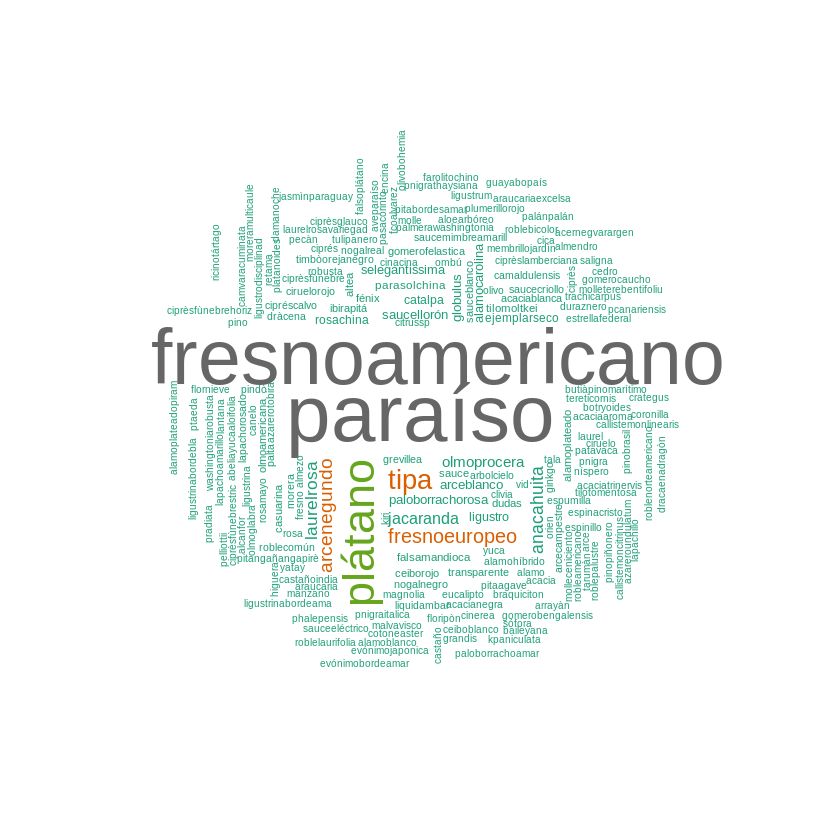

In [26]:
set.seed(1234)
wordcloud(words = d$word, freq = d$freq, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

<a id='GeolocalizacionPorEspecie'></a>
## Geolocalización por especie
[Inicio ▲](#Indice)

Del análisis anterior vemos que los Plátanos no son el árbol más común en Montevideo, si no que por el contrario están en el tercer puesto de árboles más comúnes. Ahora, ¿dónde se encuentran?

Vamos a visualizar sus posiciones en un mapa a ver si detectamos algún patrón.

In [27]:
# Usamos el dataframe crucesViasMontevideo y hacemos un join con el data frame principal
crucesViasMontevideo <- crucesViasMontevideo %>% mutate_at(c("COD_NOMBRE", "COD_NOM_01"), as.character)

In [28]:
latLongDf <- left_join(expandedDf, crucesViasMontevideo, by = c("Cod_calle"="COD_NOMBRE", "Cod_Entre"="COD_NOM_01"))

Warning message:
“Column `Cod_calle`/`COD_NOMBRE` joining factor and character vector, coercing into character vector”Warning message:
“Column `Cod_Entre`/`COD_NOM_01` joining factor and character vector, coercing into character vector”

In [29]:
colnames(latLongDf)

[1] "Arbol"             "Cod_calle"         "Calle"            
 [4] "Cod_Entre"         "Entre"             "Cod_Y"            
 [7] "Y"                 "Numero"            "Ajuste"           
[10] "Acera"             "Alineacion"        "Ordinal"          
[13] "Ancho.Vereda"      "Distancia"         "CAP"              
[16] "Altura"            "Diametro.Copa"     "EV"               
[19] "Int.Aerea"         "Int.Sub"           "Genero"           
[22] "Especie"           "Nombre.científico" "Nombre.Científico"
[25] "Nombre.común"      "porte"             "x"                
[28] "y"

In [30]:
# Selecciono solo aquellas columnas que deseo utilizar
latLongDf <- latLongDf %>% select("Arbol", "Calle", "Entre", "Nombre.científico", "Nombre.común", "x", "y")
head(latLongDf)

Arbol,Calle,Entre,Nombre.científico,Nombre.común,x,y
<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1833,18 DE JULIO AVENIDA,HERRERA Y OBES JULIO,Enterolobium contortisiliquum,"Timbò,oreja de negro","-56,19476","-34,90613"
1833,18 DE JULIO AVENIDA,HERRERA Y OBES JULIO,Enterolobium contortisiliquum,"Timbò,oreja de negro","-56,19475","-34,90618"
1834,18 DE JULIO AVENIDA,HERRERA Y OBES JULIO,Enterolobium contortisiliquum,"Timbò,oreja de negro","-56,19476","-34,90613"
1834,18 DE JULIO AVENIDA,HERRERA Y OBES JULIO,Enterolobium contortisiliquum,"Timbò,oreja de negro","-56,19475","-34,90618"
1835,18 DE JULIO AVENIDA,HERRERA Y OBES JULIO,Enterolobium contortisiliquum,"Timbò,oreja de negro","-56,19476","-34,90613"
1835,18 DE JULIO AVENIDA,HERRERA Y OBES JULIO,Enterolobium contortisiliquum,"Timbò,oreja de negro","-56,19475","-34,90618"


In [31]:
# Compruebo el nuevo dataset
dim(latLongDf)

[1] 251273      7

In [32]:
points <- latLongDf %>% 
  select(x, y, "Nombre.común") %>% filter(Nombre.común == "Plátano")

maptype = "toner-background" is only available with source = "stamen".
resetting to source = "stamen"...
Source : http://tile.stamen.com/terrain/11/702/1234.png
Source : http://tile.stamen.com/terrain/11/703/1234.png
Source : http://tile.stamen.com/terrain/11/704/1234.png
Source : http://tile.stamen.com/terrain/11/705/1234.png
Source : http://tile.stamen.com/terrain/11/702/1235.png
Source : http://tile.stamen.com/terrain/11/703/1235.png
Source : http://tile.stamen.com/terrain/11/704/1235.png
Source : http://tile.stamen.com/terrain/11/705/1235.png
Source : http://tile.stamen.com/terrain/11/702/1236.png
Source : http://tile.stamen.com/terrain/11/703/1236.png
Source : http://tile.stamen.com/terrain/11/704/1236.png
Source : http://tile.stamen.com/terrain/11/705/1236.png
Warning message:
“Removed 64171 rows containing missing values (geom_point).”

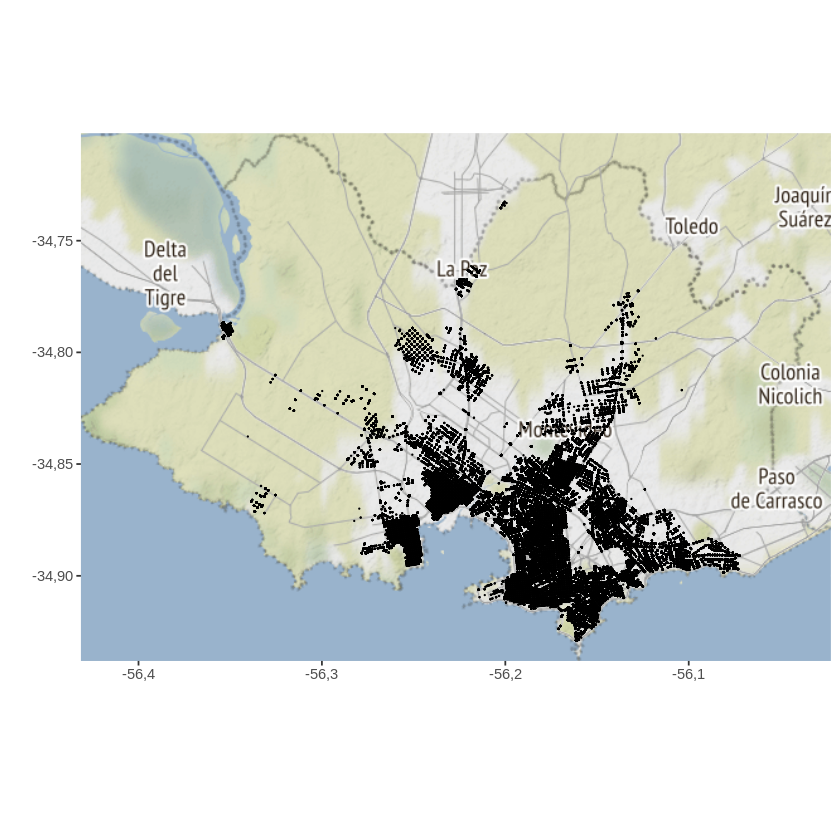

In [33]:
mad_map <- get_map(getbb("Montevideo"),maptype = "toner-background")

ggmap(mad_map)+
  labs(x="",y="")+ 
  geom_point(data=latLongDf, aes(x=x, y=y),size=0.001)

<a id='Bibliografia'></a>
## Bilbiografía
[Inicio ▲](#Indice)